# Training the Semi-Supervised GAN for Melanoma Image Classification

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import PIL
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


from os import listdir
from os.path import join
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

print(device)

cpu


In [3]:
#set random seed for reproducibility
seed = 123
random.seed(seed)
torch.manual_seed(seed)

In [5]:
#set path to data folders
path = os.getcwd()
parent = os.path.abspath(os.path.join(path, os.pardir))

transform = transforms.ToTensor()

## Setting up an Image Pipeline

Preparing a data pipeline that handles the pre-processing and augmentation of the labele dataset. Dataset classes are custom classes inheriting from the abstract Pytorch class torch.utils.data.Dataset, overiding the `__len__` and `__getitem__` methods in order to be able toget the size of the dataset via `len(dataset)` and access each datasample as `dataset[index]`. If no transform specified, datasets returning images in the form of objects of type `PIL.PngImagePlugin.PngImageFile`. Turn the images into Pytorch tensors via the Dataset class transform argument.

### Unlabeled Data Set

In [6]:
def is_image(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])

class UnlabeledDataset(Dataset):

    def __init__(self, dir_path, transform=None):
        """
        Args:
            dir_path (string): Directory containing the images.
            transform (optional): Transform to be applied on an image.
        """

        self.transform = transform
        
        # The list of all the image file names (but not the images themselves!) will be read
        # when the Dataset object is initialized
        self.image_filenames = [join(dir_path, f) for f in listdir(dir_path) if is_image(f)]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_name = self.image_filenames[idx]
        
        # Here is where the image actually gets read:
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

In [10]:
unlabeled_data_path = os.path.join(path, parent, 'Data/unlabeled/')
unlabeled_set = UnlabeledDataset(dir_path= unlabeled_data_path, transform=transform)

print('Number of images in the unlabeled set: ', len(unlabeled_set))

Number of images in the unlabeled set:  7018


### Labeled Data Set

Benign images are named *\_0.jpg*, whereas images of melanoma have filenames ending with *\_1.jpg*. The __getitem__ method returns the image with a label. 

In [11]:
class LabeledDataset(Dataset):

    def __init__(self, dir_path, transform=None):
        """
        Args:
            dir_path (string): Directory containing the images.
            transform (optional): Optional transform to be applied
                on an image.
                
            If not transform PIL.PngImagePlugin.PngImageFile    
        """

        self.transform = transform
        
        # The list of all the image file names (but not the images themselves!) will be read
        # when the Dataset object is initialized
        self.image_filenames = [join(dir_path, f) for f in listdir(dir_path) if is_image(f)]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_name = self.image_filenames[idx]
        
        # Here is where the image actually gets read:
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)
            
        label = int(img_name[-5])

        return image, label
    

In [12]:
labeled_data_path = os.path.join(path, parent, 'Data/labeled/')
labeled_set = LabeledDataset(dir_path= labeled_data_path, transform=transform)

print('Number of images in the labeled set: ', len(labeled_set))

test_data_path = os.path.join(path, parent, 'Data/test/')

Number of images in the labeled set:  200


### DataLoaders

`torch.utils.data.DataLoader` takes care of splitting the data into minibatches of a given size, shuffling it if needed, and loading it in parallel by using multiprocessing workers.

In [21]:
unlabeled_loader = DataLoader(unlabeled_set, 
                              batch_size=16, 
                              shuffle=True, 
                              num_workers=0)

labeled_loader = DataLoader(labeled_set, 
                            batch_size=16, 
                            shuffle=True, 
                            num_workers=0)

Batch labels:  tensor([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0])


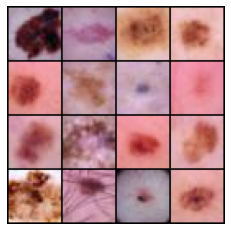

In [22]:
for batch_idx, batch in enumerate(labeled_loader):
    
    # Stop after 1 batch
    if batch_idx == 1:
        break

    print("Batch labels: ", batch[1].data)
    
    image_grid = torchvision.utils.make_grid(batch[0], nrow=4, padding=1)
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.axis("off")
    plt.pause(0.05)

### Data Augmentation

With the `torchvision.transforms` package transformations applied at random with a chosen probability, augment the unlabeled and labeled data sets making sure that the augmented dataset follows the same distribution as the original.

In [113]:
#augment the labeled data by applying randomly a list of transformations with given probability
augmentation = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.RandomRotation(0,360)])
                                    
transform = transforms.Compose([augmentation, transforms.ToTensor()])
                                          #transforms.Normalize(mean = unlabeled_mean,
                                                               #std = unlabeled_std)])                                      

In [114]:
unlabeled_set = UnlabeledDataset(unlabeled_data_path, 
                                 transform=transform)

labeled_set = LabeledDataset(labeled_data_path,     
                             transform=transform)

train_set, val_set = torch.utils.data.random_split(labeled_set, [int(0.7*len(labeled_set)), int(0.3*len(labeled_set))])

test_set = LabeledDataset(test_data_path,
                          transform=transforms.Compose([transforms.ToTensor()]))

print('Number of unlabeled train images: ', len(unlabeled_set))
print('Number of labeled train images: ', len(train_set))
print('Number of valdation images: ', len(val_set))
print('Number of test images: ', len(test_set))

Number of unlabeled train images:  7018
Number of labeled train images:  140
Number of valdation images:  60
Number of test images:  600


In [115]:
batch_size = 60
num_workers = 0

unlabeled_loader = DataLoader(unlabeled_set, 
                              batch_size=batch_size, 
                              num_workers=num_workers,
                              shuffle=True)

labeled_loader = DataLoader(train_set, 
                            batch_size=batch_size, 
                            num_workers=num_workers,
                            shuffle=True)

val_loader = DataLoader(val_set, 
                            batch_size=batch_size, 
                            num_workers=num_workers,
                            shuffle=True)

test_loader = DataLoader(dataset = test_set,
                         batch_size = batch_size,
                         num_workers = num_workers,
                         shuffle=True)

In [104]:
print("size of a training image: ", labeled_loader.dataset[0][0].size())

size of a training image:  torch.Size([3, 32, 32])


In [83]:
print("Pixels value range for training image: ", labeled_loader.dataset[0][0].min(), labeled_loader.dataset[0][0].max())

Pixels value range for training image:  tensor(0.2235) tensor(0.8549)


In [181]:
def convert_0_1(imgs, nc=3):
    #print("convert input of size: ", imgs.size())
    batch_len = imgs.size()[0]
    #print("batch size: ", batch)
    imgs = imgs.view(imgs.size(0), -1)
    #print("imgs view -1 size: ", imgs.size())
    imgs -= imgs.min(1, keepdim=True)[0]
    #print("imgs - min size: ", imgs.size())
    imgs /= imgs.max(1, keepdim=True)[0]
    #print("imgs / by max size: ", imgs.size())
    imgs = imgs.view(batch_len, nc , 32, 32)
    #print("converted output size: ",imgs.size())
    return imgs

In [171]:
dataiter = iter(labeled_loader)
images, _ = dataiter.next()

print(images.min(), images.max())

images_0_1 = (images + 1.0)/2.0
print(images_0_1.min(), images_0_1.max())

images_conv = convert_0_1(images)
print(images_conv.min(), images_conv.max())

tensor(0.) tensor(1.)
tensor(0.5000) tensor(1.)
converted output size:  torch.Size([60, 3, 32, 32])
tensor(0.) tensor(1.)


In [149]:
noise = torch.randn(num_imgs, z_dim, 1, 1, device=device)

fake_imgs = netG(noise)
fake_imgs_0_1 = convert_0_1(netG(noise))

print(fake_imgs.min(), fake_imgs.max())
print(fake_imgs_0_1.min(), fake_imgs_0_1.max())

convert input of size:  torch.Size([60, 3, 32, 32])
converted output size:  torch.Size([60, 3, 32, 32])
tensor(-0.9586, grad_fn=<MinBackward1>) tensor(0.9968, grad_fn=<MaxBackward1>)
tensor(0., grad_fn=<MinBackward1>) tensor(1., grad_fn=<MaxBackward1>)


## Unsupervised DCGAN

Makes use of the unlabeled data to boost the performance of the melanoma image classifier. An unsupervised DCGAN would generate mole-like images and train on the unlabeled dataset. The goal is not best results on generation task, but tuning the hyperparameters which will allow the generation of images in the desired domain.

In [195]:
# Number of channels of training images
nc = 3

# Latent vector dimensions  latent vector, i.e. size of generator input
z_dim = 20

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.3

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# batch of latent vectors used to visualize the progression of the generator
fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)

num_epochs = 50

In [196]:
def weights_init(m, mean=0.0, std=0.02):
    
    """ Randomly initialize the weights of the Generator and Discriminator
        to normaly distributed with mean of 0 and std of 0.2 """
    
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, mean, std)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, std)
        nn.init.constant_(m.bias.data, 0)

In [197]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #self.fc1 = nn.Linear(z_dim, 256*7*7, bias= False)
        
        self.deconv1 = nn.ConvTranspose2d(in_channels=z_dim, out_channels=ngf*4, kernel_size=4, stride=1, padding=0, bias=False)
        self.batchn1 = nn.BatchNorm2d(ngf*4)
        self.deconv2 = nn.ConvTranspose2d(in_channels=ngf*4, out_channels=ngf*2,  kernel_size=4, stride=2, padding=1, bias=False)
        self.batchn2 = nn.BatchNorm2d(ngf*2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=ngf*2, out_channels=ngf,  kernel_size=4, stride=2, padding=1, bias=False)
        self.batchn3 = nn.BatchNorm2d(ngf)
        self.deconv4 = nn.ConvTranspose2d(in_channels=ngf, out_channels=nc,  kernel_size=4, stride=2, padding=1, bias=False)
        
    def forward(self, input):
        
        x = self.deconv1(input)
        x = self.batchn1(x)
        x = F.leaky_relu(x) # default negative_slope of 0.01
        x = self.deconv2(x)
        x = self.batchn2(x)
        x = F.leaky_relu(x)
        x = self.deconv3(x)
        x = self.batchn3(x)
        x = F.leaky_relu(x)
        x = self.deconv4(x)
        
        output = torch.tanh(x) 
        
        return output

In [198]:
class unsup_Discriminator(nn.Module):
    
    def __init__(self):
        super(unsup_Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(nc, ndf, kernel_size=2, stride=2, padding=2, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchn1 = nn.BatchNorm2d(ndf*2)
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchn2 = nn.BatchNorm2d(ndf*4)
        self.conv4 = nn.Conv2d(ndf*4, 1, kernel_size=4, stride=1, padding=0, bias=False)
        
        #self.fc1   = nn.Linear(128*3*3, 1, bias=True)
        
    def forward(self, input):
        #print("input size: ", input.size())
        x = self.conv1(input)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.conv2(x)
        x = self.batchn1(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.conv3(x)
        x = self.batchn2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.conv4(x)
        
        output = torch.sigmoid(x)
        
        return output
    

In [199]:
#create and initialize the generator and discriminator
netG = Generator().to(device)
netD = unsup_Discriminator().to(device)

netG.apply(weights_init)
netD.apply(weights_init)

unsup_Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

In [200]:
#init the BCELoss function
loss_fn = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Epoch 1/50
------------------------------
 Avg. Discriminator loss: 0.9648, Avg Generator loss: 2.0904

Epoch  1


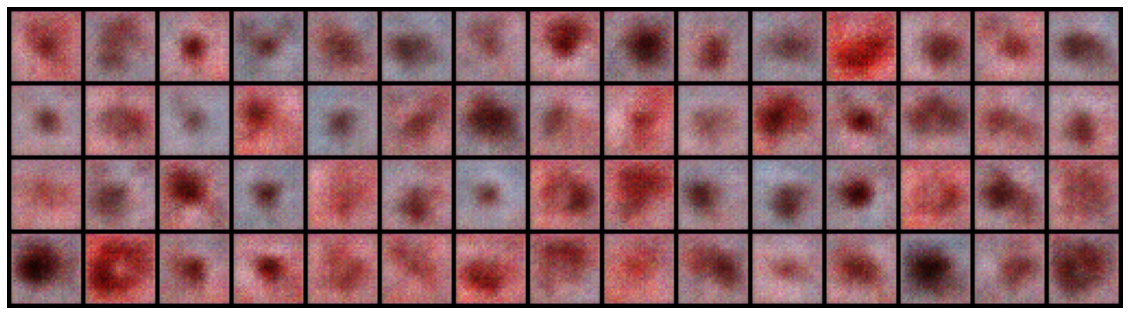

Epoch 2/50
------------------------------
 Avg. Discriminator loss: 1.0787, Avg Generator loss: 1.6781

Epoch 3/50
------------------------------
 Avg. Discriminator loss: 1.1300, Avg Generator loss: 1.5082

Epoch 4/50
------------------------------
 Avg. Discriminator loss: 1.1633, Avg Generator loss: 1.3729

Epoch 5/50
------------------------------
 Avg. Discriminator loss: 1.1946, Avg Generator loss: 1.2818

Epoch 6/50
------------------------------
 Avg. Discriminator loss: 1.2199, Avg Generator loss: 1.2183

Epoch 7/50
------------------------------
 Avg. Discriminator loss: 1.2437, Avg Generator loss: 1.1720

Epoch 8/50
------------------------------
 Avg. Discriminator loss: 1.2597, Avg Generator loss: 1.1352

Epoch 9/50
------------------------------
 Avg. Discriminator loss: 1.2729, Avg Generator loss: 1.1046

Epoch 10/50
------------------------------
 Avg. Discriminator loss: 1.2828, Avg Generator loss: 1.0827

Epoch 11/50
------------------------------
 Avg. Discriminator 

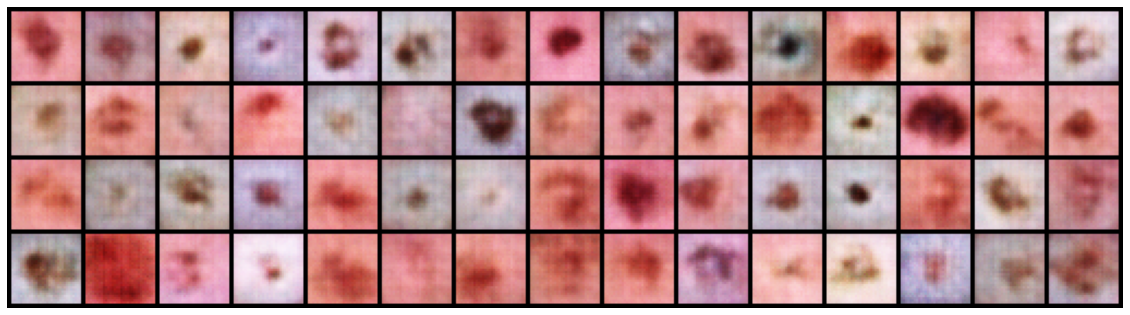

Epoch 12/50
------------------------------
 Avg. Discriminator loss: 1.2970, Avg Generator loss: 1.0516

Epoch 13/50
------------------------------
 Avg. Discriminator loss: 1.3024, Avg Generator loss: 1.0402

Epoch 14/50
------------------------------
 Avg. Discriminator loss: 1.3075, Avg Generator loss: 1.0312

Epoch 15/50
------------------------------
 Avg. Discriminator loss: 1.3107, Avg Generator loss: 1.0241

Epoch 16/50
------------------------------
 Avg. Discriminator loss: 1.3140, Avg Generator loss: 1.0190

Epoch 17/50
------------------------------
 Avg. Discriminator loss: 1.3165, Avg Generator loss: 1.0151

Epoch 18/50
------------------------------
 Avg. Discriminator loss: 1.3188, Avg Generator loss: 1.0122

Epoch 19/50
------------------------------
 Avg. Discriminator loss: 1.3201, Avg Generator loss: 1.0108

Epoch 20/50
------------------------------
 Avg. Discriminator loss: 1.3210, Avg Generator loss: 1.0126

Epoch 21/50
------------------------------
 Avg. Discri

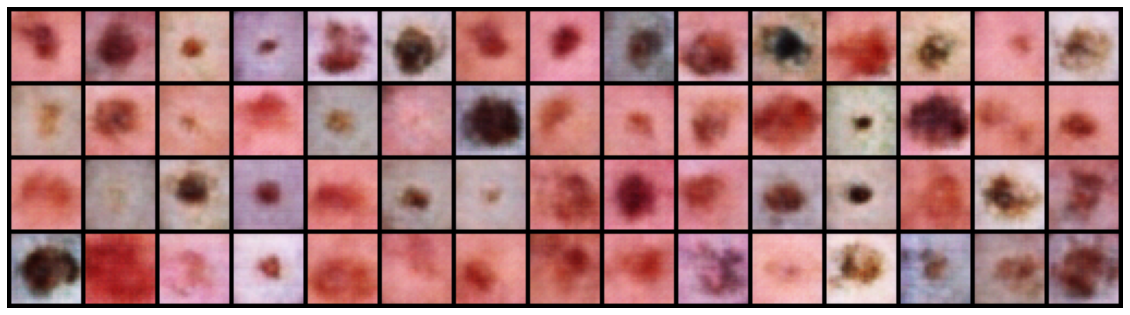

Epoch 22/50
------------------------------
 Avg. Discriminator loss: 1.3192, Avg Generator loss: 1.0241

Epoch 23/50
------------------------------
 Avg. Discriminator loss: 1.3150, Avg Generator loss: 1.0378

Epoch 24/50
------------------------------
 Avg. Discriminator loss: 1.3067, Avg Generator loss: 1.0632

Epoch 25/50
------------------------------
 Avg. Discriminator loss: 1.2928, Avg Generator loss: 1.0994

Epoch 26/50
------------------------------
 Avg. Discriminator loss: 1.2776, Avg Generator loss: 1.1405

Epoch 27/50
------------------------------
 Avg. Discriminator loss: 1.2630, Avg Generator loss: 1.1801

Epoch 28/50
------------------------------
 Avg. Discriminator loss: 1.2498, Avg Generator loss: 1.2185

Epoch 29/50
------------------------------
 Avg. Discriminator loss: 1.2362, Avg Generator loss: 1.2526

Epoch 30/50
------------------------------
 Avg. Discriminator loss: 1.2216, Avg Generator loss: 1.2863

Epoch 31/50
------------------------------
 Avg. Discri

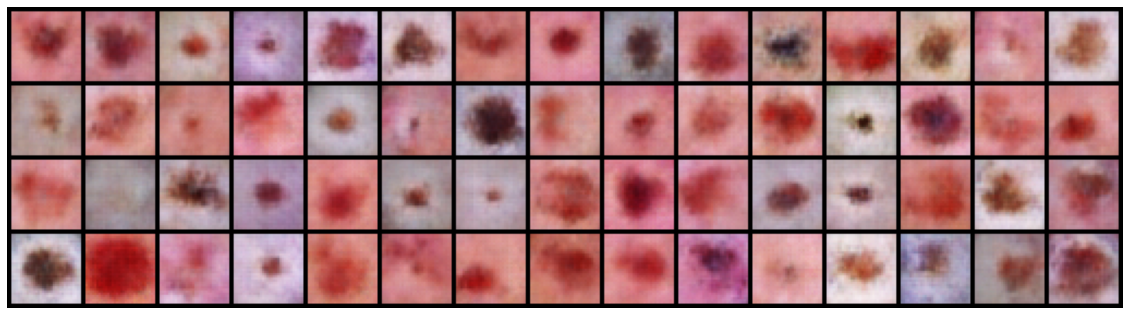

Epoch 32/50
------------------------------
 Avg. Discriminator loss: 1.1947, Avg Generator loss: 1.3521

Epoch 33/50
------------------------------
 Avg. Discriminator loss: 1.1803, Avg Generator loss: 1.3842

Epoch 34/50
------------------------------
 Avg. Discriminator loss: 1.1700, Avg Generator loss: 1.4115

Epoch 35/50
------------------------------
 Avg. Discriminator loss: 1.1574, Avg Generator loss: 1.4371

Epoch 36/50
------------------------------
 Avg. Discriminator loss: 1.1451, Avg Generator loss: 1.4658

Epoch 37/50
------------------------------
 Avg. Discriminator loss: 1.1341, Avg Generator loss: 1.4904

Epoch 38/50
------------------------------
 Avg. Discriminator loss: 1.1232, Avg Generator loss: 1.5129

Epoch 39/50
------------------------------
 Avg. Discriminator loss: 1.1135, Avg Generator loss: 1.5369

Epoch 40/50
------------------------------
 Avg. Discriminator loss: 1.1032, Avg Generator loss: 1.5594

Epoch 41/50
------------------------------
 Avg. Discri

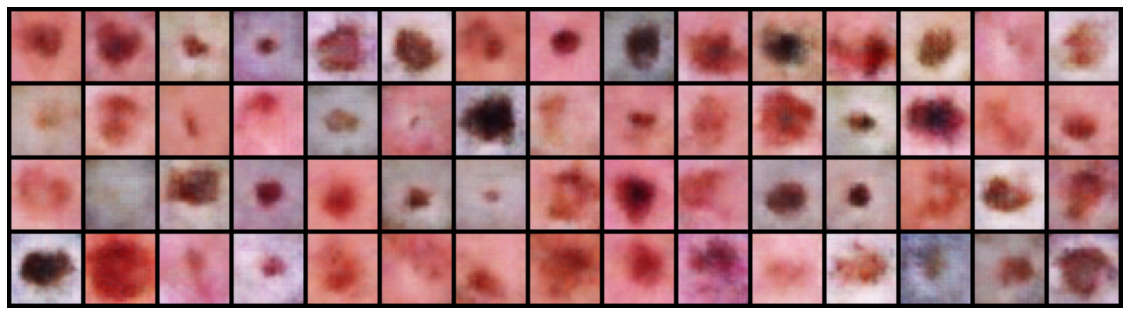

Epoch 42/50
------------------------------
 Avg. Discriminator loss: 1.0864, Avg Generator loss: 1.5936

Epoch 43/50
------------------------------
 Avg. Discriminator loss: 1.0776, Avg Generator loss: 1.6131

Epoch 44/50
------------------------------
 Avg. Discriminator loss: 1.0713, Avg Generator loss: 1.6279

Epoch 45/50
------------------------------
 Avg. Discriminator loss: 1.0614, Avg Generator loss: 1.6475

Epoch 46/50
------------------------------
 Avg. Discriminator loss: 1.0534, Avg Generator loss: 1.6650

Epoch 47/50
------------------------------
 Avg. Discriminator loss: 1.0474, Avg Generator loss: 1.6804

Epoch 48/50
------------------------------
 Avg. Discriminator loss: 1.0404, Avg Generator loss: 1.6967

Epoch 49/50
------------------------------
 Avg. Discriminator loss: 1.0350, Avg Generator loss: 1.7114

Epoch 50/50
------------------------------
 Avg. Discriminator loss: 1.0276, Avg Generator loss: 1.7266



In [201]:
display_every = 10

G_losses = []
D_losses = []

for epoch in range(num_epochs):
        
    #for each batch in the train loader
    for batch_idx, real_imgs in enumerate(unlabeled_loader):

        num_imgs = real_imgs.size()[0]
        
        real_imgs.to(device)
               
        ###############################################################
        #                                                             #
        # Update Discirminator: maximize log(D(x)) + log(1 - D(G(z))) #
        #                                                             #
        ###############################################################
                  
        optimizerD.zero_grad()
              
        #################### Train with real images ###################
        
        labels = torch.full((num_imgs,), real_label, dtype=torch.float, device = device)
       
        output = netD(real_imgs).view(-1)
        
        # Discriminator losses on real images
        real_lossD =  loss_fn(output, labels)
        
        # compute the gradients for Discriminator in backward pass
        real_lossD.backward() #retain_graph=True
                
        ################### Train with fake images ########################
        
        # generate batch of latent vectors - tensors with random numbers from the standart normal distr 
        noise = torch.randn(num_imgs, z_dim, 1, 1, device=device)
        
        # generate batch of fake images 
        fake_imgs = (netG(noise)+1.0)/2
        
        labels = torch.full((num_imgs,), fake_label, dtype=torch.float, device = device)
        
        # classify the batch of fake images with the Discriminator
        output = netD(fake_imgs.detach()).view(-1) 
        
        # compute the Discriminator losses on batch of fake images
        fake_lossD =  loss_fn(output, labels) #output.squeeze()
        
        # compute the gradient of the fake images loss w.r.t. Discriminator model parameters
        fake_lossD.backward() #retain_graph=True
        
        # add up losses from classifing a batch of real and  a batch of fake images
        lossD = real_lossD + fake_lossD
    
        #save losses for ploting
        D_losses.append(lossD.item())
        
        # update the Discriminator weights
        optimizerD.step()   
           
        ###############################################################
        #                                                             #
        #           Update Generator: maximize log(D(G(z)))           #
        #                                                             #
        ###############################################################
        
        optimizerG.zero_grad()
            
        # since the generator's goal is to get netD(fake_images) = 1, flip the labels for computing Generator's loss
        labels = torch.full((num_imgs,), real_label, dtype=torch.float, device = device)    
        
        # perform another forward pass with the batch of fake images through the Discriminator, after it was updated in the previus step
        output = netD(fake_imgs).view(-1)
        
        # compute the Generator's loss on this output
        lossG = loss_fn(output, labels) 
        
        # save losses for plotting
        G_losses.append(lossG.item())
        
        # compute the gradient of the fake images (called "real") loss w.r.t. Generator model parameters
        lossG.backward()
        
        # update the Generator weights
        optimizerG.step()
        
        ###############################################################
        #                                                             #
        #                    Output training stats                    #
        #                                                             #
        ###############################################################
        
    # print out training stats
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-'*30)
    print(' Avg. Discriminator loss: {:6.4f}, Avg Generator loss: {:6.4f}'.format(sum(D_losses)/len(D_losses), sum(G_losses)/len(G_losses)))
    print()  
    
    # check how the Generator is doing by displaing the fixed noise generated fake images
    if epoch % display_every == 0:
        netG.eval()
        with torch.no_grad():
            generated = (netG(fixed_noise).detach().cpu()+1)/2
            
            image_grid = torchvision.utils.make_grid(generated, nrow=15)
        
            print("Epoch ", epoch + 1)
            plt.figure(figsize=(20,10))
            plt.imshow(image_grid.permute(1, 2, 0))
            plt.axis("off")
            plt.pause(0.05)
        netG.train()    
        

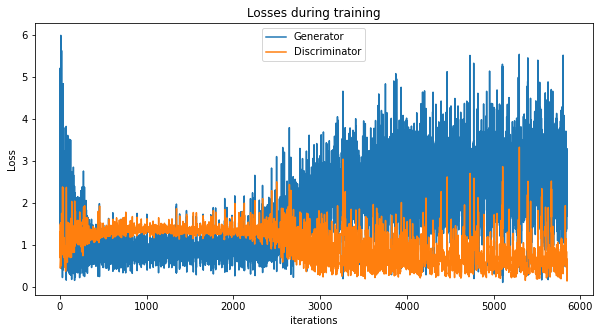

In [202]:
plt.figure(figsize=(10,5))
plt.title("Losses during training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Comparison of the fake, generated images with a batch of real training images:

(-0.5, 511.5, 137.5, -0.5)

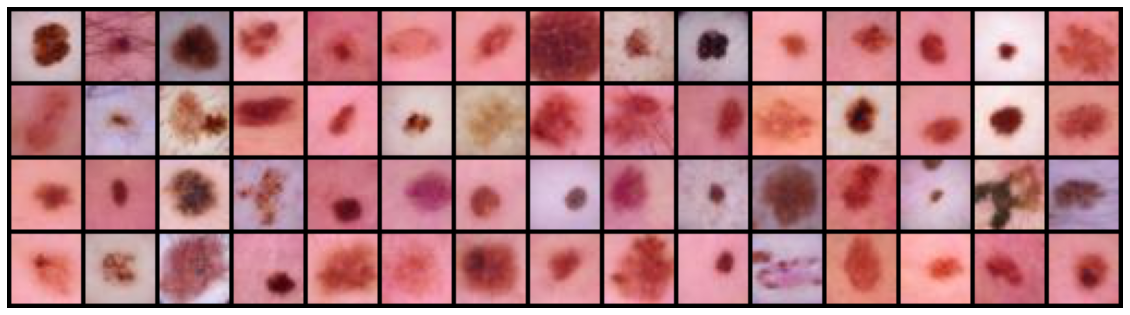

In [207]:
dataiter = iter(unlabeled_loader)
images = dataiter.next()

image_grid = torchvision.utils.make_grid(images, nrow=15)

plt.figure(figsize=(20,10))
plt.imshow(image_grid.permute(1, 2, 0))
plt.axis("off")

## Semi-supervised GAN out of DCGAN

In [208]:
def create_dir(directory):
    
    """Creates a directory if it does not already exist."""
    if not os.path.exists(directory):
        os.makedirs(directory)
   

In [209]:
data_root = os.path.join(path, parent, 'Data/')
gener_img_dir = "generated_Melanoma"
check_pt_dir = "/models_wts/Melanoma_SGAN/"

create_dir(data_root + gener_img_dir)
create_dir(path + check_pt_dir)

In [210]:
def checkpoint(epoch, G, D, optimizerG, optimizerD, lossG, lossD):
    """
    Saves the parameters of the generator G and discriminator D
    and other checkpoints for finetuning, Adam optimizer has internal
    parameters which would be reset to default values
    """
    Melanoma_SGAN_path = os.getcwd() + check_pt_dir + 'SGAN.pkl'  
    # serializes the object with python pickle
    torch.save({
            'epoch': epoch,
            'G_state_dict': G.state_dict(),
            'D_state_dict': D.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(), #
            'optimizerD_state_dict': optimizerD.state_dict(),
            'lossG': lossG,
            'lossD': lossD
            }, Melanoma_SGAN_path)
    
def load_checkpoint(model, check_pt_name):
    # unpickling to deserialize the saved object with torch.load; 
    model.load_state_dict(torch.load(os.getcwd() + check_pt_dir + check_pt_name))

In [211]:
best_model_path = os.getcwd() + check_pt_dir + "best_discriminator_wts.pkl"

In [212]:
print(best_model_path)

/Users/elliemcintosh/Documents/Python/ManningBooks_LiveProjects/MelanomaDetection/Code/models_wts/Melanoma_SGAN/best_discriminator_wts.pkl


In [213]:
def binary_predict(x):
    
    """ Transoforms the 2 neurons output of the last fully
        connected layer into a binary, real vs fake output
        
           D(x)= Z(x)/Z(x)+1 where Z(x)=Sum(exp[l(x)])
           
        where x is an input image, and l are the logits from 
        the final layer of the classifier. The sum over logits 
        goes from 1 to 2 (number of classes). The value of D(x)
        is close to 1 when a strong prediction has been made for 
        one of the 2 (real) classes, and close to zero when the 
        2 logits' values are small."""   
    
    # .sum(dim) Returns the sum of each row of the input tensor in the given dimension dim
    # dim = -1 means the last dimension
    Z = torch.exp(x).sum(dim = -1)
    D = Z/(Z + 1.0)
    
    if torch.isnan(D).sum() > 0:
        print("binary real vs fake prediction contains na: ", D)
    
    return D

In [214]:
num_classes = 2

class Discriminator(nn.Module):
    
    
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(nc, ndf, kernel_size=2, stride=2, padding=2, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchn1 = nn.BatchNorm2d(ndf*2)
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchn2 = nn.BatchNorm2d(ndf*4)
        self.conv4 = nn.Conv2d(ndf*4, ndf*2, kernel_size=4, stride=1, padding=0, bias=False)
        
        # fully connected layer with 2 output classes
        self.fc1     = nn.Linear(ndf*2, num_classes, bias=False) 
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input):
        x = self.conv1(input)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.conv2(x)
        x = self.batchn1(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.conv3(x)
        x = self.batchn2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.conv4(x)
        x = x.view(-1, ndf*2)
        
        x = self.fc1(x)
        
        binary_out = binary_predict(x)
        class_out  = self.softmax(x.squeeze())   
        
        return binary_out, class_out
        

In [216]:
#create and initialize the generator and discriminator
netG = Generator().to(device)
netD = Discriminator(num_classes).to(device)

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (fc1): Linear(in_features=128, out_features=2, bias=False)
  (softmax): Softmax(dim=1)
)

In [217]:
# check if discriminator works
dataiter = iter(labeled_loader)
images, labels = dataiter.next()

labeled_binary, labeled_class = netD(images)


In [218]:
dataiter = iter(unlabeled_loader)
images = dataiter.next()

unlabeled_binary, unlabeled_class = netD(images)


In [219]:
noise = torch.randn(num_imgs, z_dim, 1, 1, device=device)

fake_imgs = netG(noise)
fake_binary, fake_class = netD(fake_imgs.detach())


In [220]:
# Initialize the loss functions
bce_loss = nn.BCELoss()
cce_loss = nn.CrossEntropyLoss()

In [222]:
loss_supervised = cce_loss(labeled_class, labels)
print(loss_supervised)

tensor(0.7017, grad_fn=<NllLossBackward>)


In [223]:
#Set up Adam optimizers for the Generator and Discriminator
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr = lr, betas=(beta1, 0.999))

In [224]:
# check if loading works
for i in range(2):
    labeled_imgs, labeles = next(iter(labeled_loader))
    unlabeled_imgs = next(iter(unlabeled_loader))
    
    print(labeled_imgs.size())
    print(labeles.size())
    print(unlabeled_imgs.size())

torch.Size([60, 3, 32, 32])
torch.Size([60])
torch.Size([60, 3, 32, 32])
torch.Size([60, 3, 32, 32])
torch.Size([60])
torch.Size([60, 3, 32, 32])


In [246]:
def test(model, device, data_loader, display=True):
    
    """Evaluates the model's performance on validation or test dataset"""

    test_loss = 0
    correct = 0

    test_acc = []

    model.eval()
    with torch.no_grad():
        
        for imgs, labels in data_loader:
            
            
            binary_output, class_output = netD(imgs.to(device))
        
            test_loss += cce_loss(class_output, labels.to(device)).item()
            
            pred = class_output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.to(device).data.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    if display:
        print('\nValidation Average Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(data_loader.dataset), 100. * correct/len(data_loader.dataset)))
           
    return np.round(test_loss, 4), np.round(100.*correct/len(data_loader.dataset), 2)
            
    #avg_loss = np.round(test_loss/len(data_loader.dataset), 4)
    #accuracy = 100. * correct/len(data_loader.dataset)  
    
    #print("Test Avg Loss: {:.4f}, Discriminator Test Accuracy: {:.2f} %".format(avg_loss, accuracy))
        
    #return avg_loss, accuracy

In [241]:
num_epochs = 50
num_iter = np.ceil(len(labeled_loader.dataset)/batch_size).astype(int)

fixed_fake_imgs =[]

# Lists to keep track of progress
G_losses = []
D_losses = []

epoch_losses = []
train_loss = []
train_cntr = []

val_losses =[]
val_accuracies =[]

fixed_fake_list = []

best_model_wts = torch.save(netD.state_dict(), "best_discriminator_wts")
best_acc = 0.0

displ_imgs = batch_size

for epoch in range(num_epochs):
    
    print("\nEpoch {}/{}".format(epoch +1, num_epochs))
    print('-'*30)
            
    #for each iteration
    for i in range(num_iter):
        
        real_labeled_imgs, real_class_labels = next(iter(labeled_loader))
        
        real_unlabeled_imgs = next(iter(unlabeled_loader))
        num_imgs = real_labeled_imgs.size()[0]
        
        real_labeled_imgs.to(device)
        real_class_labels.to(device)
        
        real_unlabeled_imgs.to(device)  
        
        # make binary labeles for the real unlabeled images and for the fake generated images               
        real_binary_labels = torch.full((num_imgs,), real_label, dtype=torch.float, device = device)
        fake_binary_labels = torch.full((num_imgs,), fake_label, dtype=torch.float, device = device)
               
        ###############################################################
        #                                                             #
        #                      Train the Discriminator                #
        #                                                             #
        ###############################################################
        
        netD.train()
        optimizerD.zero_grad()
            
        ################### On Unlabeled Images #######################
        # instead of rescaling the real images, rescale the fake images
        # from [-1, 1] to [0, 1]
        
        binary_real, _ = netD(real_unlabeled_imgs)
        
        binary_real_loss = 0.5 * bce_loss(binary_real, real_binary_labels)
        
        binary_real_loss.backward()      
        
        ################### On Generated Images ####################### 
        
        noise = torch.randn(num_imgs, z_dim, 1, 1, device=device)
        
        fake_imgs = (netG(noise) + 1.0)/2.0
        
        binary_fake, _ = netD(fake_imgs.detach()) 
        
        binary_fake_loss = 0.5 * bce_loss(binary_fake, fake_binary_labels)
        
        binary_fake_loss.backward()
        
        loss_unsupervised = binary_real_loss + binary_fake_loss
                
        ####################### On Labeled Images ######################
        # instead of rescaling the real images, rescale the fake images
        # from [-1, 1] to [0, 1]
        
        _, class_real  = netD(real_labeled_imgs)
        
        # supervised loss
        loss_supervised = cce_loss(class_real, real_class_labels)
        
        train_loss.append(loss_supervised.item())
        train_cntr.append((i+1)*num_imgs + epoch * len(labeled_loader.dataset))
  
        loss_supervised.backward() #retain_graph=True
        
        ###################### update Discriminator ####################

        lossD = loss_supervised + loss_unsupervised
        
        train_loss.append(lossD.item())
        train_cntr.append((i+1)*num_imgs + epoch * len(labeled_loader.dataset))
  
        #lossD.backward(retain_graph=True)
        
        optimizerD.step()
        
        ###############################################################
        #                                                             #
        #                      Train the Generator                    #
        #                                                             #
        ###############################################################
        
        netG.train()
        optimizerG.zero_grad()
        
        binary_fake, _ = netD(fake_imgs)
        
        lossG = bce_loss(binary_fake, real_binary_labels)
        
        lossG.backward()
        
        optimizerG.step()  
        
        # save losses for plotting
        G_losses.append(lossG.item())
        D_losses.append(lossD.item()) 
                
        ###############################################################
        #                                                             #
        #                    Output training stats                    #
        #                                                             #
        ###############################################################
        
        # Calculate discriminator validation loss and accuracy
        val_loss, val_accuracy = test(netD, device, val_loader)
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_discriminator_wts = torch.save(netD.state_dict(), os.getcwd() + check_pt_dir + "best_discriminator_wts.pkl")
    
            print("Discriminator best Validation Accuracy {:.2f} %".format(best_acc))
            checkpoint(epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses)
            


Epoch 1/50
------------------------------

Validation Average Loss: 0.0009, Accuracy: 48/60 (80%)

Discriminator best Validation Accuracy 80.00 %

Validation Average Loss: 0.0010, Accuracy: 43/60 (72%)


Validation Average Loss: 0.0009, Accuracy: 46/60 (77%)


Epoch 2/50
------------------------------

Validation Average Loss: 0.0010, Accuracy: 40/60 (67%)


Validation Average Loss: 0.0009, Accuracy: 44/60 (73%)


Validation Average Loss: 0.0009, Accuracy: 47/60 (78%)


Epoch 3/50
------------------------------

Validation Average Loss: 0.0009, Accuracy: 46/60 (77%)


Validation Average Loss: 0.0009, Accuracy: 47/60 (78%)


Validation Average Loss: 0.0009, Accuracy: 45/60 (75%)


Epoch 4/50
------------------------------

Validation Average Loss: 0.0009, Accuracy: 47/60 (78%)


Validation Average Loss: 0.0009, Accuracy: 44/60 (73%)


Validation Average Loss: 0.0009, Accuracy: 44/60 (73%)


Epoch 5/50
------------------------------

Validation Average Loss: 0.0010, Accuracy: 38/60 (63%


Validation Average Loss: 0.0009, Accuracy: 46/60 (77%)


Validation Average Loss: 0.0009, Accuracy: 44/60 (73%)


Epoch 39/50
------------------------------

Validation Average Loss: 0.0009, Accuracy: 48/60 (80%)


Validation Average Loss: 0.0010, Accuracy: 41/60 (68%)


Validation Average Loss: 0.0009, Accuracy: 48/60 (80%)


Epoch 40/50
------------------------------

Validation Average Loss: 0.0009, Accuracy: 46/60 (77%)


Validation Average Loss: 0.0009, Accuracy: 46/60 (77%)


Validation Average Loss: 0.0009, Accuracy: 46/60 (77%)


Epoch 41/50
------------------------------

Validation Average Loss: 0.0009, Accuracy: 45/60 (75%)


Validation Average Loss: 0.0009, Accuracy: 48/60 (80%)


Validation Average Loss: 0.0009, Accuracy: 46/60 (77%)


Epoch 42/50
------------------------------

Validation Average Loss: 0.0009, Accuracy: 46/60 (77%)


Validation Average Loss: 0.0009, Accuracy: 46/60 (77%)


Validation Average Loss: 0.0009, Accuracy: 47/60 (78%)


Epoch 43/50
-------------

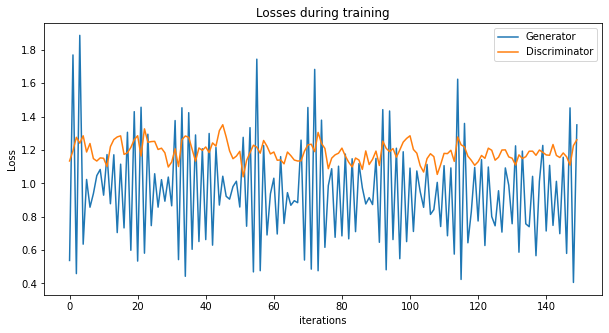

In [242]:
plt.figure(figsize=(10,5))
plt.title("Losses during training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

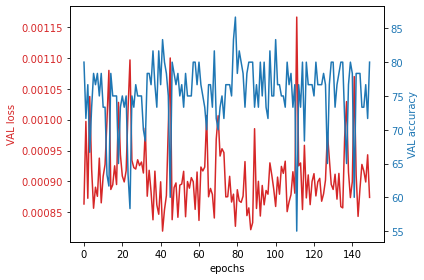

Highest accuracy on the VAL set:  86.6667


In [243]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('VAL loss', color=color)
ax1.plot(range(len(np.array(val_losses))), np.array(val_losses), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('VAL accuracy', color=color)  
ax2.plot(range(len(np.array(val_losses))), np.array(val_accuracies), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()
   
print('Highest accuracy on the VAL set: ', np.max(val_accuracies))

Text(0.5, 0, 'Iterations')

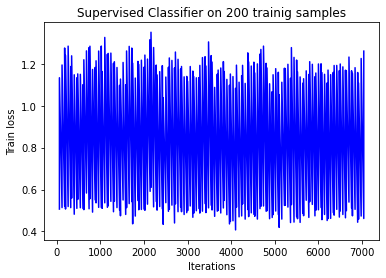

In [244]:
# Plot Discriminator as a supervised classifier training performance
plt.plot(train_cntr, train_loss, color='blue')
plt.title("Supervised Classifier on 200 trainig samples")
plt.ylabel('Train loss')
plt.xlabel('Iterations')

In [253]:
# load best model weights
netD.load_state_dict(torch.load(best_model_path))

test_loss, test_acc = test(netD, device, test_loader, display=False) 
print("\nBest SGAN model test accuracy: ",test_acc)


Best SGAN model test accuracy:  75.83


### Melanoma Classifier models performance comparison

Compare the test accuracies of the Melanoma classifiers:

* Supervised model trained from scratch: 78%
* Supervised transfer learning DenseNet121: 76%
* Semi-supervised GAN: 79%

The semi-supervised model attains higher accuracy than both supervised models trained from scratch and pre-trained on the ImageNet. Further improvements may be limited by the small number of labeled samples, but also by the low resolution of the images and the difficulty of the classification task, which poses a problem even for experienced medical professionals. 